In [43]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
dataframe = pd.read_csv("SP500DATA.csv")
print(dataframe)# Text file data converted to integer data type
Shillerdataframe = pd.read_csv("S&P500 Schiller PE ratio.csv")
print(Shillerdataframe)

           Date    Price     Open     High      Low Vol.  Change %
0    01/12/2021  4766.18  4623.80  4808.52  4494.20    -    0.0436
1    01/11/2021  4567.00  4616.47  4743.74  4560.26    -   -0.0083
2    01/10/2021  4605.38  4324.71  4608.70  4278.70    -    0.0691
3    01/09/2021  4307.54  4531.04  4544.58  4304.90    -   -0.0476
4    01/08/2021  4522.68  4415.90  4537.80  4369.20    -    0.0290
..          ...      ...      ...      ...      ...  ...       ...
618  01/06/1970    72.72    76.55    79.96    72.25    -   -0.0500
619  01/05/1970    76.55    81.52    82.32    68.61    -   -0.0610
620  01/04/1970    81.52    89.63    90.70    79.31    -   -0.0905
621  01/03/1970    89.63    89.50    91.07    86.19    -    0.0015
622  01/02/1970    89.50    85.02    90.33    84.64    -    0.0527

[623 rows x 7 columns]
                 DateTime  SP500PERatio
0     1871-01-01 00:00:58         11.10
1     1871-02-01 00:00:58         11.25
2     1871-03-01 00:00:58         11.52
3     1871-0

# Step 1

In [44]:
trainData = dataframe[["Price", "Open"]].to_numpy(dtype = 'float')
targetData = dataframe[["Price"]].to_numpy(dtype = 'float')
date = dataframe[["Date"]].to_numpy(dtype = "str")

norm = MinMaxScaler(feature_range = (0, 1))
trainData = norm.fit_transform(trainData)
targetData = norm.fit_transform(targetData)
trainData = np.flip(trainData)
targetData = np.flip(targetData)
date = np.flip(date)

dateAxis = []
for i in range(date.shape[0]):
    dateAxis.append(float(np.squeeze(date)[i][6:10]) + float(np.squeeze(date)[i][3:5])/12.0)
dateAxis = np.array(dateAxis)
dateAxis_test=date[438:623,:]
dateAxis = dateAxis[6:620]
print(dateAxis.shape)

(614,)


In [45]:
X = []
Y = []
for i in range(trainData.shape[0] - 5 - 4):
    X.append(trainData[i:i+6])
    Y.append(targetData[i+6:i+6+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)
Y.shape

(614, 1, 4)

In [46]:
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []

X_fullTraining, X_test, Y_fullTraining, Y_test, date_ft, date_t = train_test_split(X, Y, dateAxis, test_size=0.3, shuffle=False)
X_training, X_validation, Y_training, Y_validation, date_tr, date_v = train_test_split(X_fullTraining, Y_fullTraining, date_ft, test_size=0.3, shuffle=False)

date_test=date[438:623,:]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


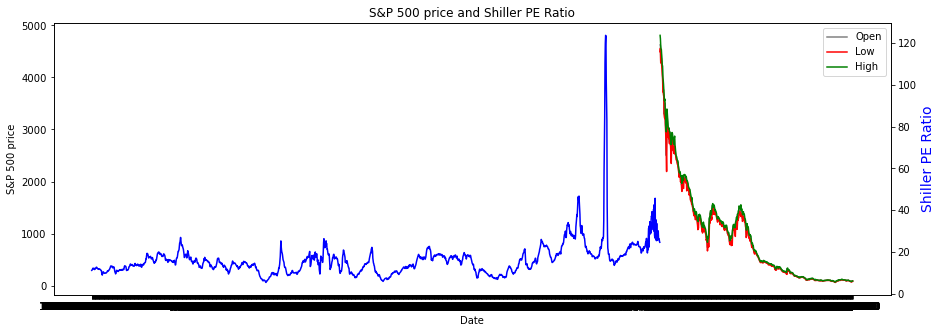

In [47]:
plt.figure(figsize=(15, 5));
plt.plot(dataframe.Date, dataframe.Open.values, color='grey', label='Open')
# plt.plot(dataframe.Date, dataframe.Close.values, color='black', label='Close')
plt.plot(dataframe.Date, dataframe.Low.values, color='red', label='Low')
plt.plot(dataframe.Date, dataframe.High.values, color='green', label='High')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(Shillerdataframe.DateTime, Shillerdataframe.SP500PERatio.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.savefig('price_pe.eps')
plt.show()

# Step 2

In [5]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   

        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
    
        out = self.fc(out)
    
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [6]:
RNN = Model(input_size=2, output_size=4, hidden_dim=16, n_layers=1)
optimizer = torch.optim.Adam(RNN.parameters(), lr=0.01)
criterion = nn.MSELoss()
RNN

Model(
  (rnn): RNN(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

# Step 3

In [7]:
xTensor = torch.from_numpy(X_fullTraining).float()
yTensor = torch.Tensor(Y_fullTraining).float()

for epoch in range(100):
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss:", loss.item())

Epoch: 0/100............. Loss: 0.011990378610789776
Epoch: 10/100............. Loss: 0.004506485536694527
Epoch: 20/100............. Loss: 0.0013543152017518878
Epoch: 30/100............. Loss: 0.0005537199322134256
Epoch: 40/100............. Loss: 0.00020508430316112936
Epoch: 50/100............. Loss: 0.00016138672071974725
Epoch: 60/100............. Loss: 0.00010917408508248627
Epoch: 70/100............. Loss: 0.00010177123476751149
Epoch: 80/100............. Loss: 9.689322178019211e-05
Epoch: 90/100............. Loss: 9.445450996281579e-05


In [8]:
def prediction_error(pred, actual):
    return abs(pred - actual)/pred

In [9]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_fullTrainingplt = norm.inverse_transform(Y_fullTraining[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.042475,0.037122,1.780044,5.240131
2 day,0.038384,0.033769,1.997702,6.688010
3 day,0.043307,0.038270,1.900458,5.884267
4 day,0.055882,0.046316,1.414105,2.923775


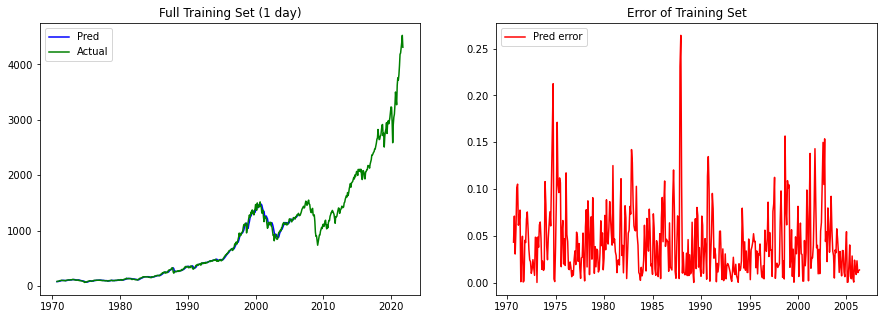

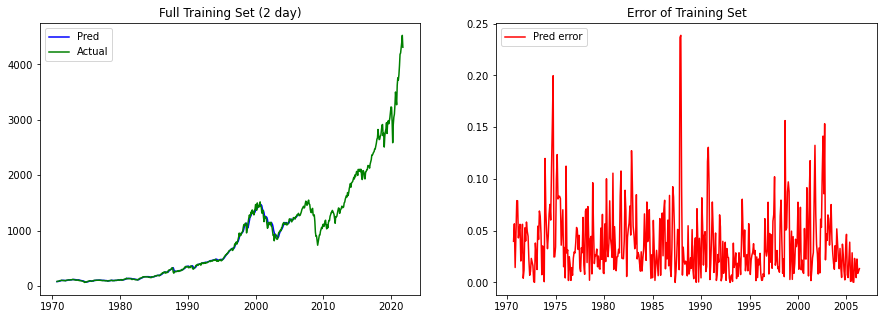

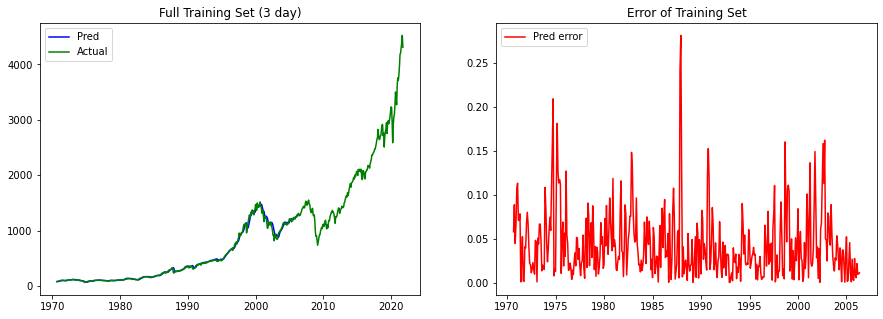

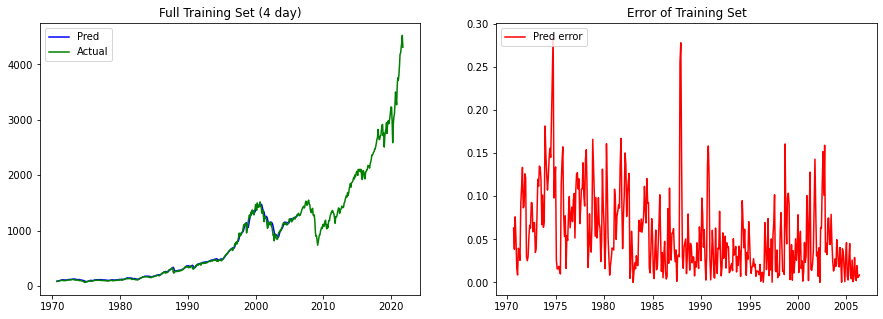

In [10]:
table = []

error = prediction_error(output_plt1, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (1 day)")
ax1.plot(date_ft, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (2 day)")
ax1.plot(date_ft, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (3 day)")
ax1.plot(date_ft, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (4 day)")
ax1.plot(date_ft, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 4 

In [11]:
RNN.eval()
xTensor = torch.from_numpy(X_test).float()
output, _ = RNN(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.071596,0.057885,1.445570,1.718727
2 day,0.073060,0.061742,1.446188,1.725351
3 day,0.077155,0.063455,1.459822,1.652363
4 day,0.068063,0.056001,1.436584,1.588965


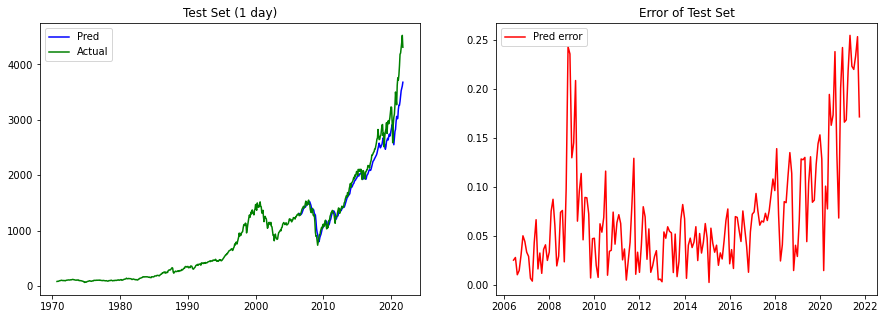

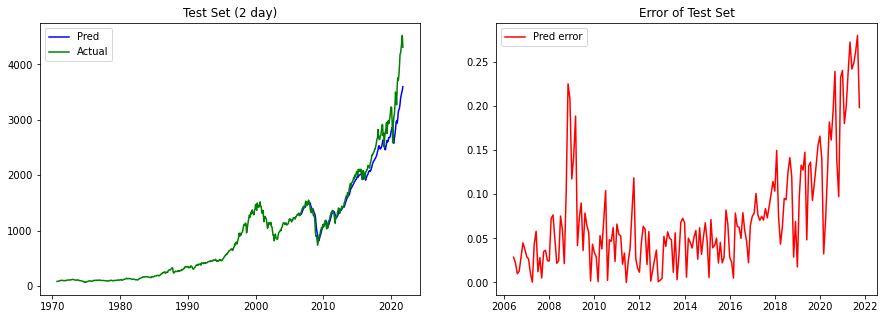

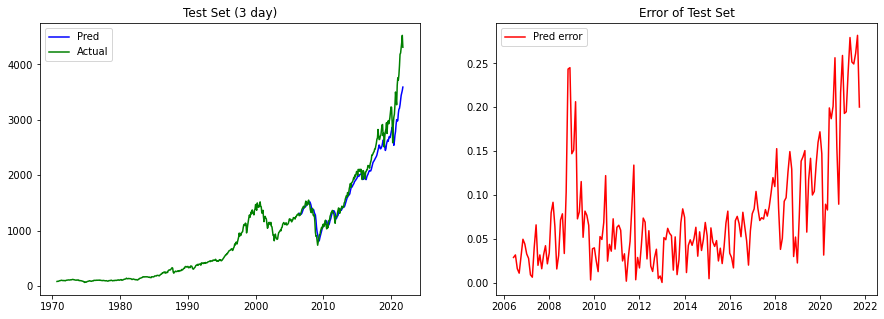

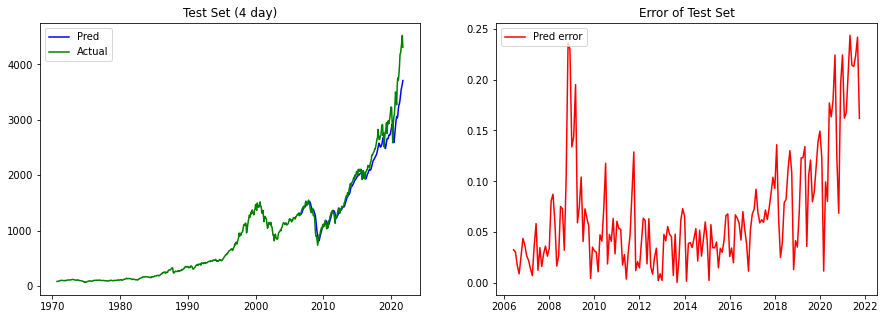

In [12]:
table = []

error = prediction_error(output_plt1, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (1 day)")
ax1.plot(date_t, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (2 day)")
ax1.plot(date_t, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (3 day)")
ax1.plot(date_t, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)
                  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (4 day)")
ax1.plot(date_t, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 5

In [13]:
RNNval = Model(input_size=2, output_size=4, hidden_dim=32, n_layers=2)
optimizerVal = torch.optim.Adam(RNNval.parameters(), lr=0.002)
criterionVal = nn.MSELoss()
RNNval

xTensor = torch.from_numpy(X_training).float()
yTensor = torch.Tensor(Y_training).float()

for epoch in range(200):
    optimizerVal.zero_grad()
    
    output, hidden = RNNval(xTensor)
    loss = criterionVal(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizerVal.step()
    
    if epoch%100 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 200), end=' ')
        print("Loss:", loss.item())

Epoch: 0/200............. Loss: 0.016383230686187744
Epoch: 100/200............. Loss: 1.859702570072841e-05


In [14]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_trainingplt = norm.inverse_transform(Y_training[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.051474,0.043528,1.619572,4.367578
2 day,0.053028,0.044147,1.657594,4.666224
3 day,0.055513,0.045492,1.665304,4.832771
4 day,0.057521,0.045995,1.588869,4.347602


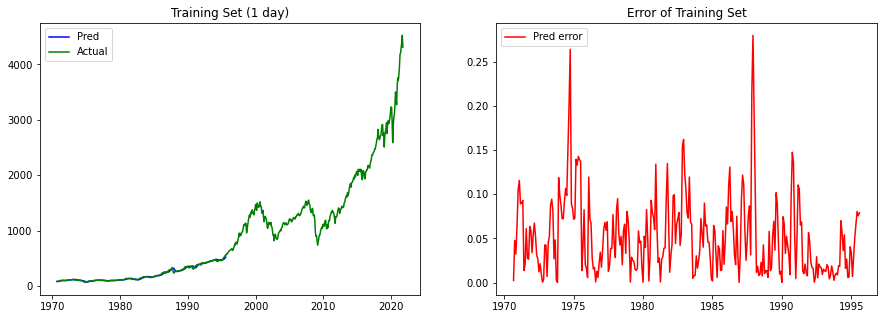

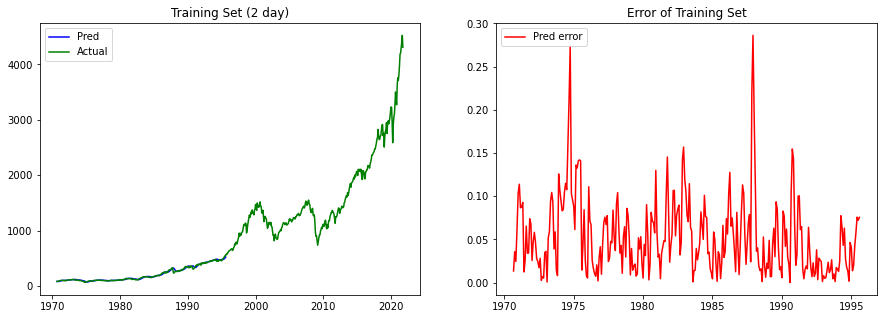

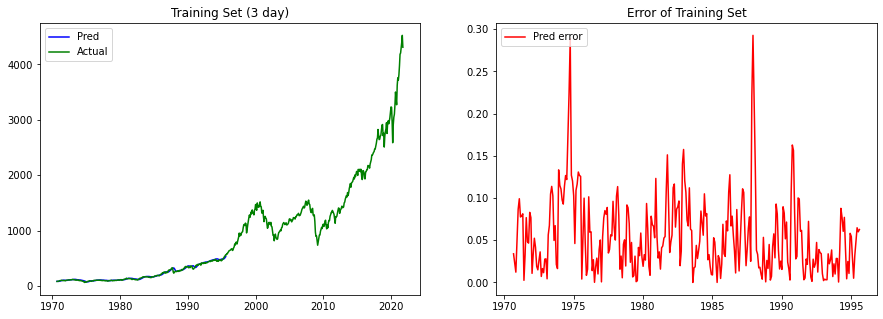

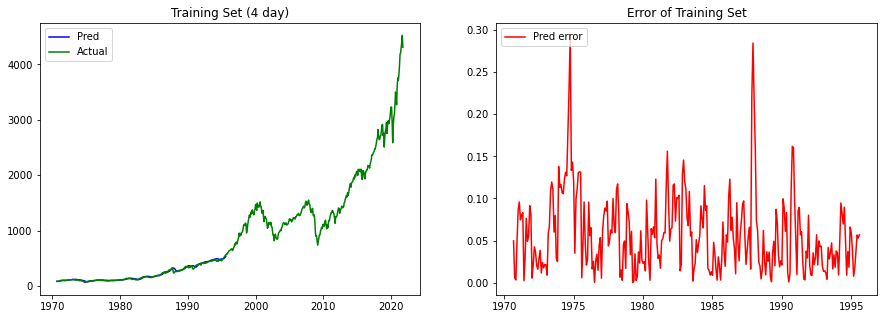

In [15]:
table = []

error = prediction_error(output_plt1, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (1 day)")
ax1.plot(date_tr, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (2 day)")
ax1.plot(date_tr, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (3 day)")
ax1.plot(date_tr, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (4 day)")
ax1.plot(date_tr, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

In [16]:
RNNval.eval()
xTensor = torch.from_numpy(X_validation).float()
output, _ = RNNval(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_validationplt = norm.inverse_transform(Y_validation[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.086467,0.046684,0.487039,0.046800
2 day,0.084837,0.046050,0.524486,-0.040383
3 day,0.056608,0.041962,1.025720,0.992467
4 day,0.051730,0.041916,1.246615,1.761662


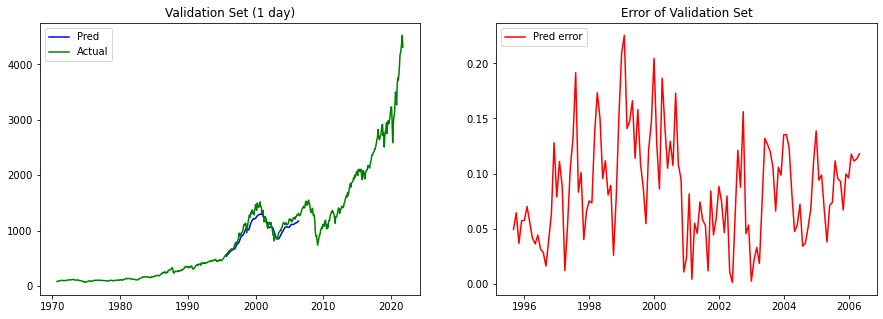

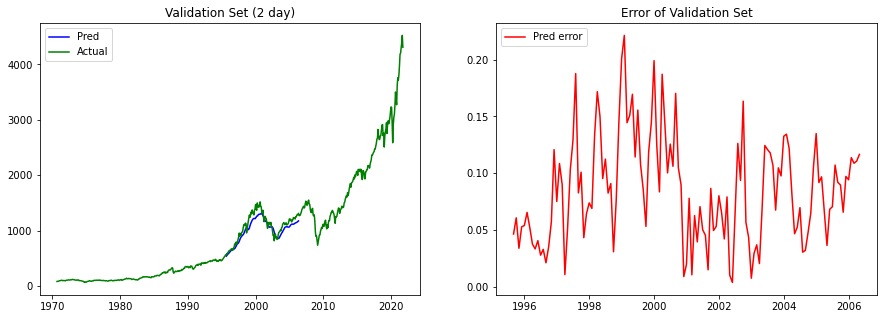

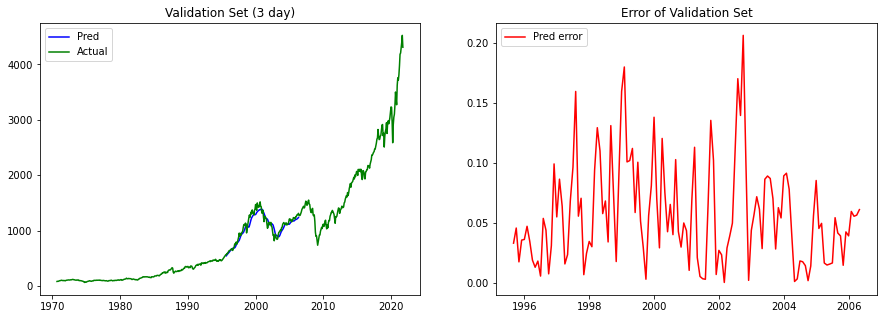

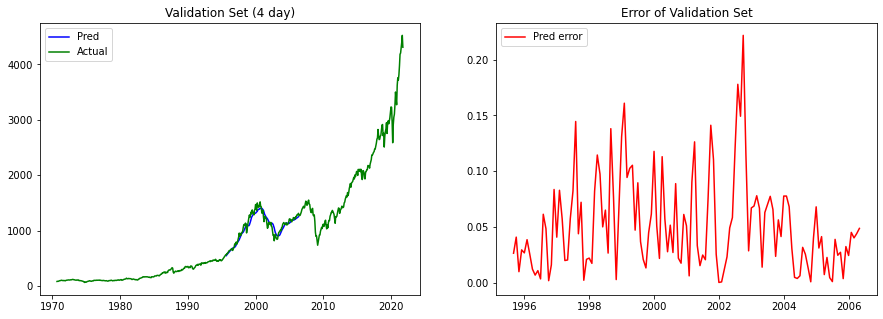

In [17]:
table = []

error = prediction_error(output_plt1, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (1 day)")
ax1.plot(date_v, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (2 day)")
ax1.plot(date_v, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (3 day)")
ax1.plot(date_v, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (4 day)")
ax1.plot(date_v, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

In [18]:
xTensor = torch.from_numpy(X_test).float()
output, _ = RNNval(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.291004,0.225611,1.330082,1.466703
2 day,0.285653,0.220929,1.324821,1.471979
3 day,0.212691,0.186958,1.500910,2.031557
4 day,0.191628,0.170755,1.488945,1.998639


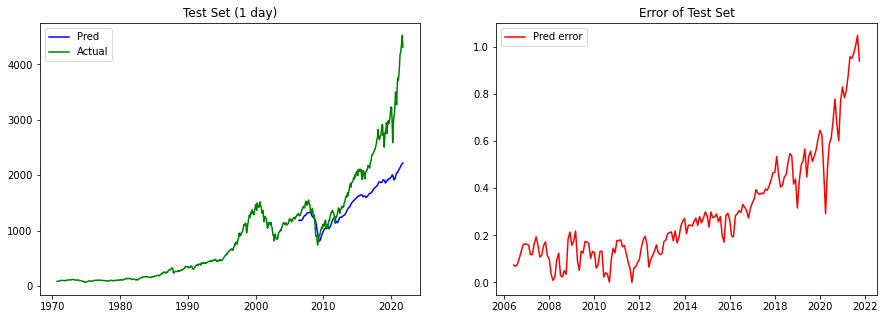

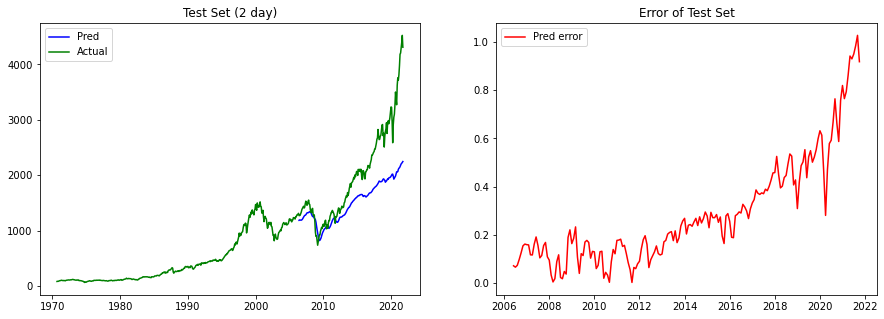

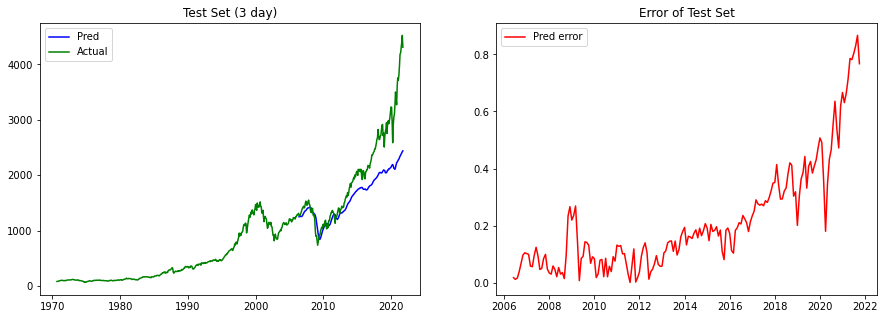

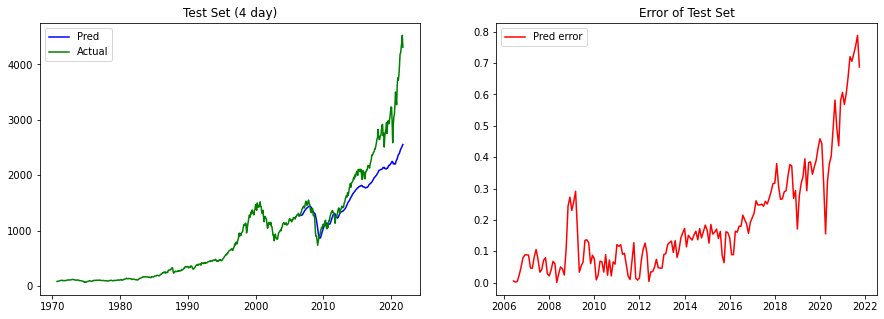

In [19]:
table = []

error = prediction_error(output_plt1, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (1 day)")
ax1.plot(date_t, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (2 day)")
ax1.plot(date_t, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (3 day)")
ax1.plot(date_t, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (4 day)")
ax1.plot(date_t, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 6

In [20]:
def predict(day_index):
    out_temp = np.concatenate( (Y_test[:, :, day_index], Y_test[:, :, day_index], Y_test[:, :, day_index]), axis = 1)
    target = norm.inverse_transform(out_temp)[:, [0]]
    error_res_all = []
    for sigma in stdev:
        noisy_data = NoisyTesting(X_test, sigma)
        inputs = Variable(torch.from_numpy(noisy_data).float())
        output, _ = RNNval(inputs)
        out_temp = np.concatenate((output.detach().numpy()[:, [day_index]], 
                                   output.detach().numpy()[:, [day_index]],  
                                   output.detach().numpy()[:, [day_index]]), axis=1)
        predicted_price = norm.inverse_transform(out_temp)[:, [0]]
        error = prediction_error(target, predicted_price)
        error_res_all.append(error.reshape(-1))
    return error_res_all

In [21]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
def FullGraphing(day):
    plt.figure(1, figsize=(15, 5))
    for i in range(len(stdev)): 
        #print(np.shape(date_test))
        #print(np.shape(error_res_all[i]))
        #print(np.shape(cmaps[i]))
        plt.plot(np.squeeze(date_test), error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  

    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next ' +day+ ' day)')
    plt.legend(loc="lower right") 

In [22]:
def IndividualGraphing(day):
    for i in range(len(stdev)): 
        plt.figure(1, figsize=(15, 5))
        plt.plot(np.squeeze(date_test), error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  
        plt.xlabel('Date')
        plt.ylabel('Prediction error')
        plt.title('Prediction error with Different Noise Levels (next '+day+' day)')
        plt.legend(loc="lower right")  
        plt.show()

In [23]:
print("NOISY")
stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]

def NoisyTesting(dataset, sigma):
    noisy_data = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(6):
        s = np.random.normal(0, sigma, 20)
        index = random.sample(list(range(180)), 20)
        noisy_data[i] = dataset[i]
        noisy_data[index, i, 0] = noisy_data[index, i, 0] + s
    return noisy_data

NOISY


,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.068568,0.068664,0.068539,0.068516,0.068108,0.070054,0.070174,0.066957,0.065856,0.065667
01/09/2006,0.064161,0.063601,0.063756,0.065101,0.064687,0.067094,0.058619,0.069702,0.059342,0.097537
01/10/2006,0.070756,0.070756,0.070756,0.070756,0.070756,0.070756,0.070756,0.070756,0.070756,0.070756
01/11/2006,0.091703,0.091659,0.091919,0.092360,0.092142,0.092994,0.075269,0.099975,0.094438,0.115638
01/12/2006,0.114278,0.114278,0.114278,0.114278,0.114278,0.114278,0.114278,0.114278,0.114278,0.114278
...,...,...,...,...,...,...,...,...,...,...
01/08/2021,0.984729,0.984729,0.984729,0.984551,0.967904,0.923519,0.923606,0.967513,0.927888,0.932880
01/09/2021,0.985061,0.985061,0.985061,0.985061,0.985061,0.985061,0.985061,0.984914,0.985061,0.985061
01/10/2021,0.985393,0.985393,0.985393,0.985603,0.985512,0.986017,0.969106,0.985914,0.984840,0.968976
01/11/2021,0.985804,0.985804,0.985804,0.985804,0.985804,0.985816,0.985803,0.986307,0.985781,0.985031


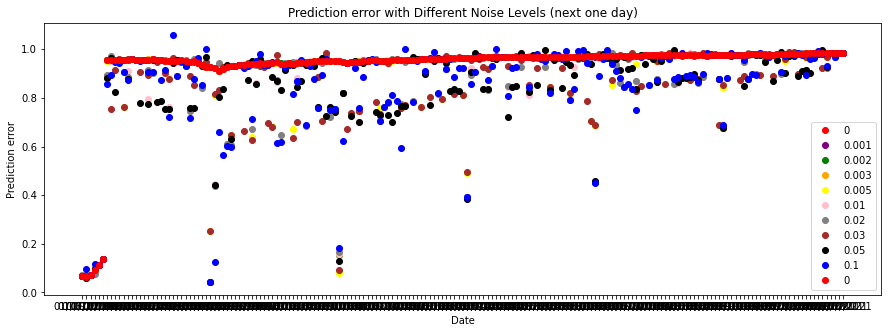

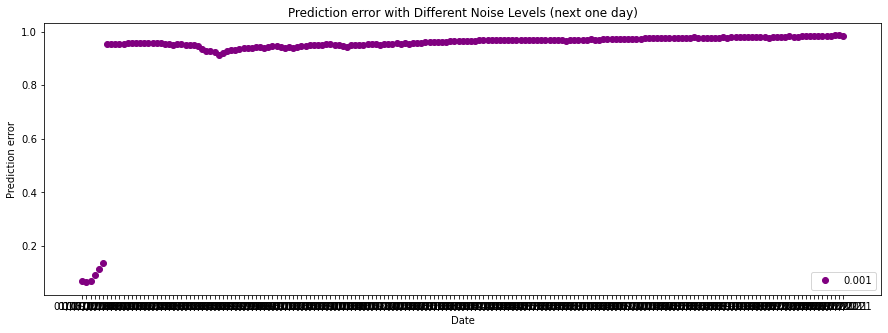

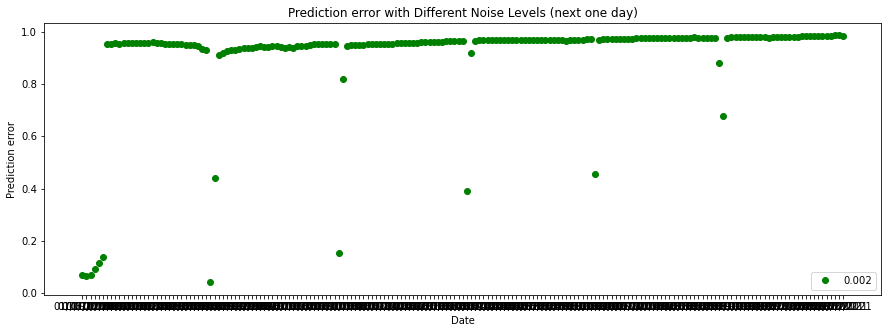

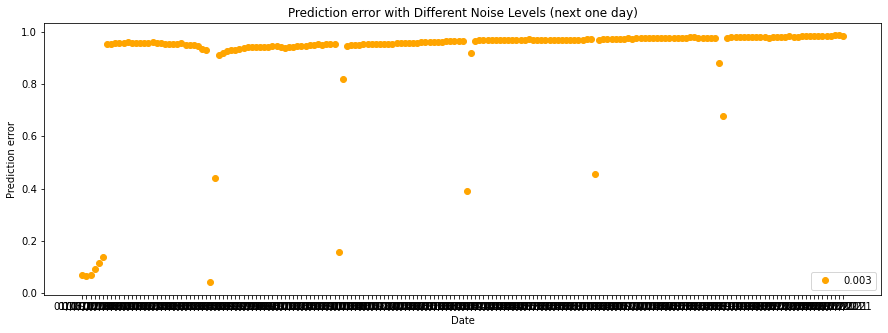

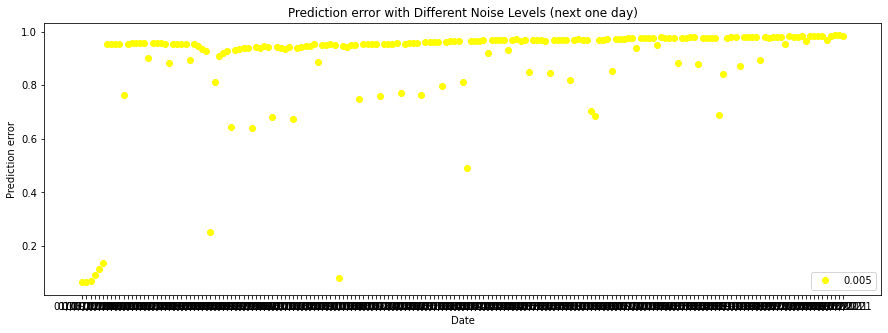

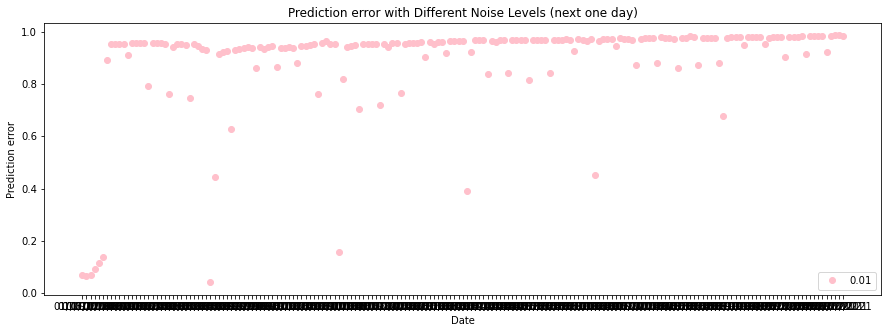

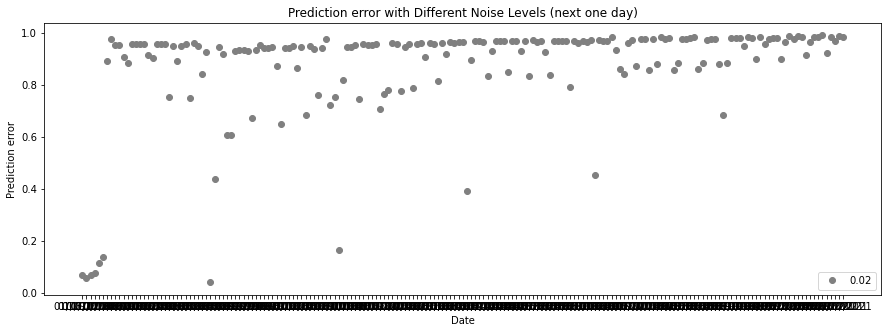

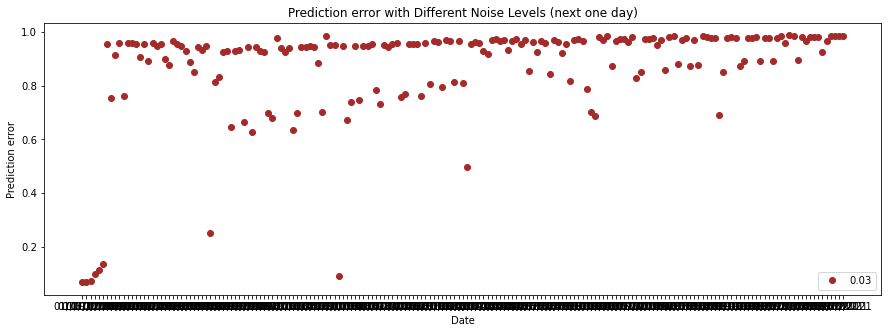

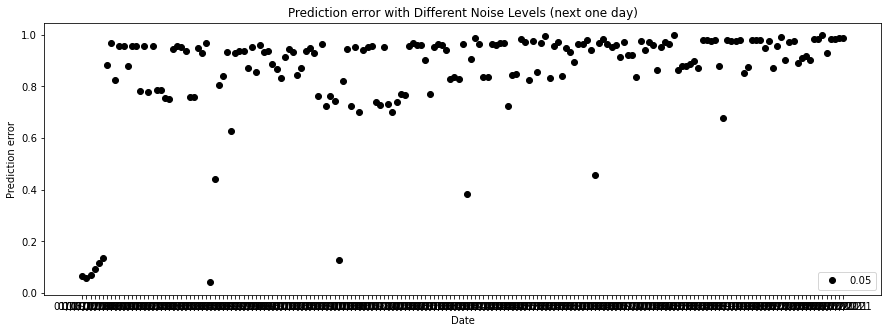

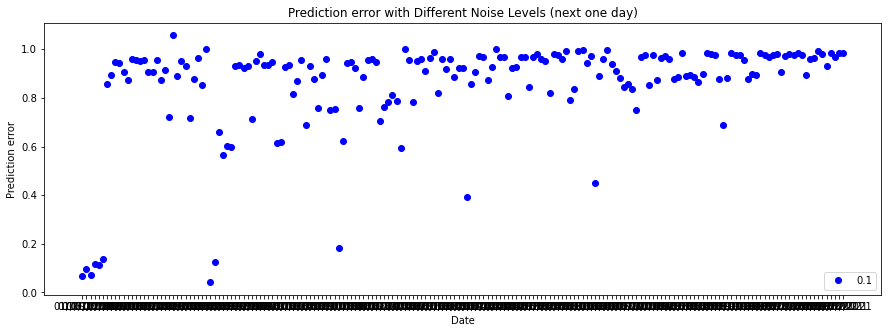

In [24]:
error_res_all=predict(0)

labels = date_test[:,0]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("one")
IndividualGraphing("one")

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.067033,0.067149,0.067102,0.067230,0.067386,0.066434,0.066012,0.069456,0.064624,0.067857
01/09/2006,0.066676,0.066410,0.066196,0.065126,0.064315,0.069961,0.069108,0.068082,0.039022,0.031738
01/10/2006,0.088038,0.088038,0.088038,0.088038,0.088038,0.088038,0.088038,0.088038,0.088038,0.088038
01/11/2006,0.110876,0.110662,0.110041,0.111340,0.110685,0.113125,0.115930,0.110984,0.054194,0.135513
01/12/2006,0.138130,0.138130,0.138130,0.138130,0.138130,0.138130,0.138130,0.138130,0.138130,0.138130
...,...,...,...,...,...,...,...,...,...,...
01/08/2021,0.931836,0.985018,0.929397,0.800361,0.929397,0.944199,0.924317,0.603561,0.933237,1.273468
01/09/2021,0.985351,0.985351,0.985174,1.260924,0.985174,0.762420,0.985351,0.729939,0.951066,0.520162
01/10/2021,0.951103,0.985764,0.985670,0.724902,0.985670,0.537179,0.986149,0.434595,0.935681,0.740492
01/11/2021,0.983985,0.985053,0.983889,1.228641,0.983889,0.379322,0.985053,0.322582,0.983552,0.605716


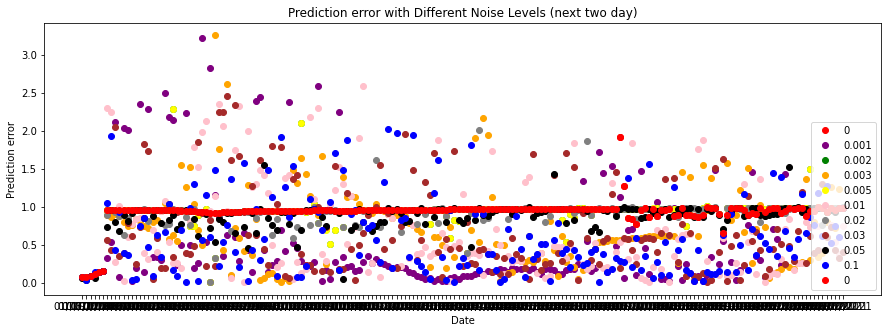

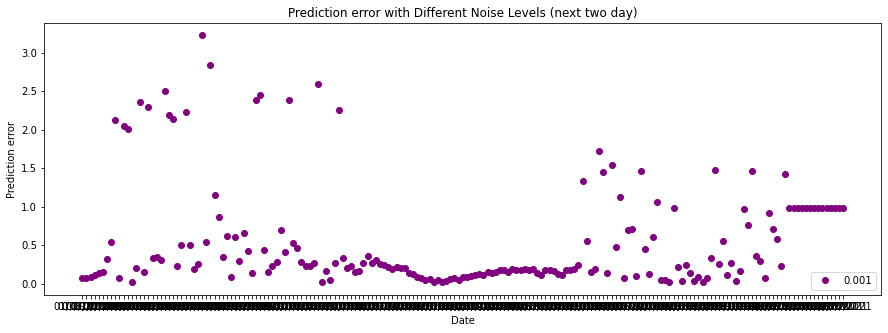

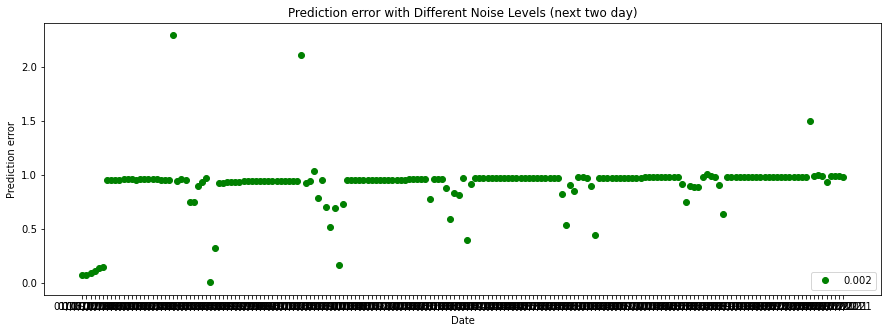

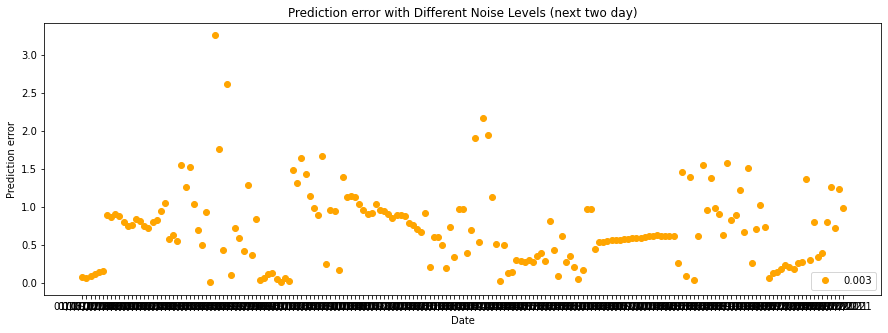

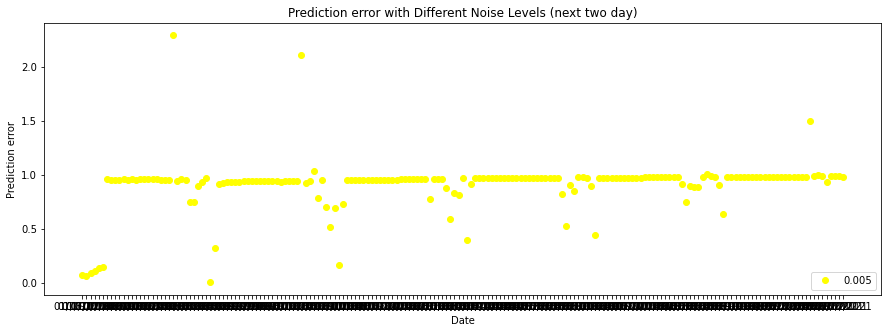

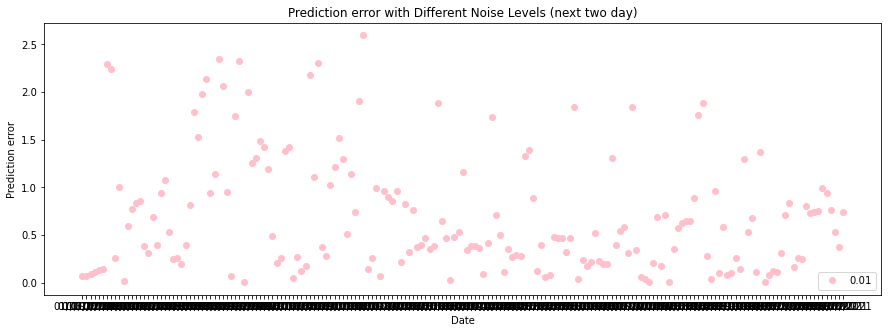

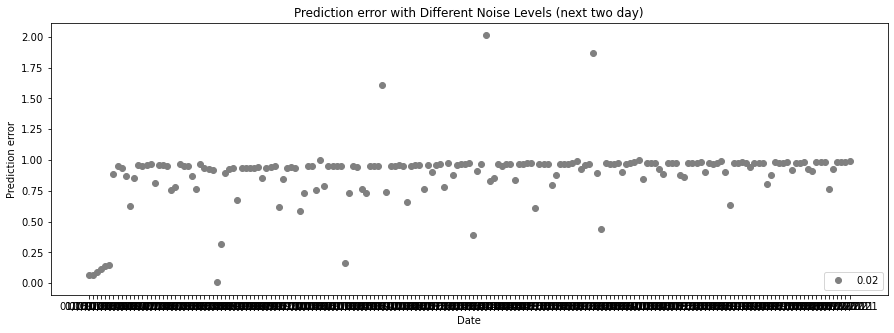

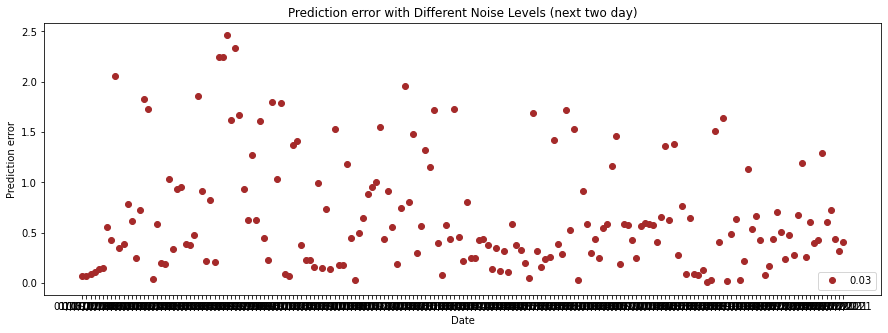

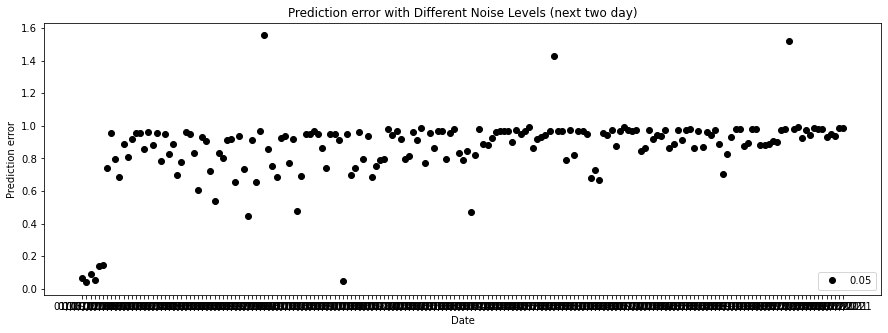

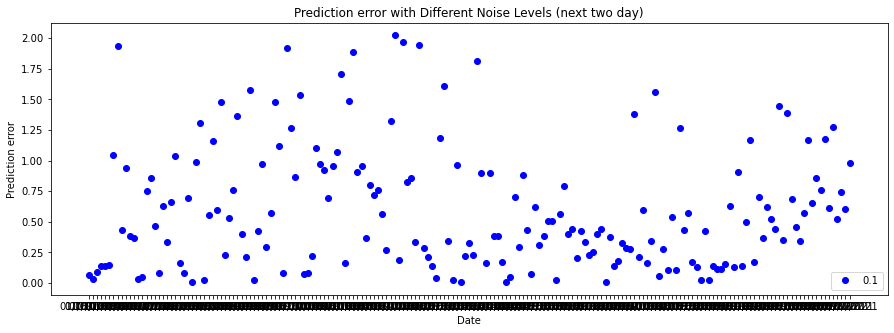

In [25]:
error_res_all=predict(1)

output.detach().numpy()[:,0:1]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("two")
IndividualGraphing("two")

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.022066,0.022099,0.022097,0.022235,0.022021,0.022277,0.026043,0.023268,0.023913,0.020434
01/09/2006,0.036785,0.037036,0.037057,0.037709,0.037391,0.035323,0.047724,0.006485,0.048238,0.003627
01/10/2006,0.059220,0.059220,0.059220,0.059220,0.059220,0.059220,0.059220,0.059220,0.059220,0.059220
01/11/2006,0.088756,0.089397,0.088502,0.089880,0.086248,0.092846,0.091692,0.073194,0.081499,0.060924
01/12/2006,0.105907,0.105907,0.105907,0.105907,0.105907,0.105907,0.105907,0.105907,0.105907,0.105907
...,...,...,...,...,...,...,...,...,...,...
01/08/2021,0.329225,0.934166,1.228178,0.951564,0.515706,0.908132,0.494597,0.910717,0.642320,0.879755
01/09/2021,1.303799,0.985385,1.192309,0.985385,1.058608,0.976180,1.178176,0.940766,0.844238,0.943445
01/10/2021,0.316372,0.926712,1.115186,0.990943,0.842097,0.940817,0.393585,0.989081,1.141556,0.977546
01/11/2021,0.518053,0.984422,0.311418,0.984320,0.985648,0.971053,0.393705,0.989589,0.712906,0.915855


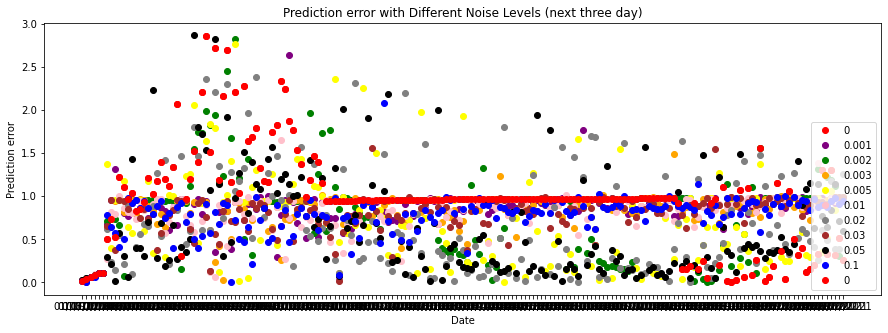

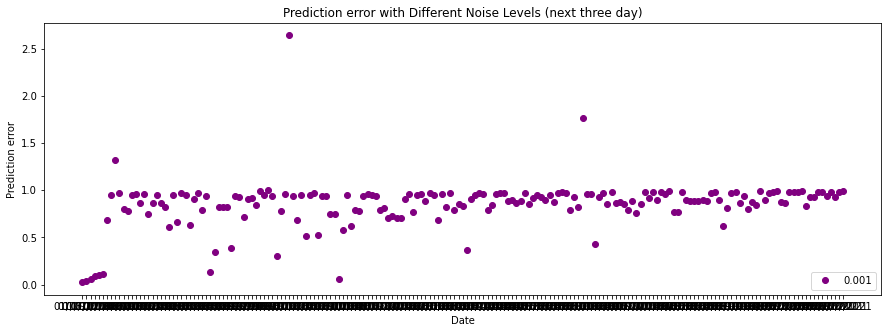

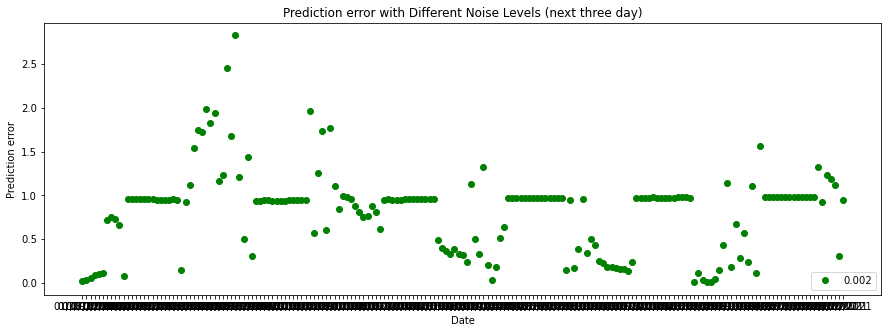

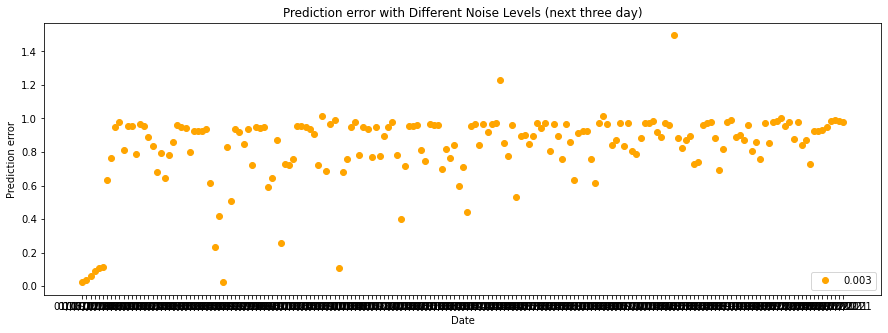

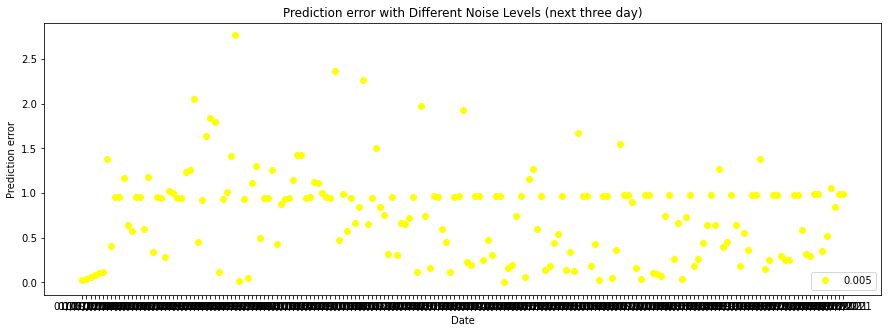

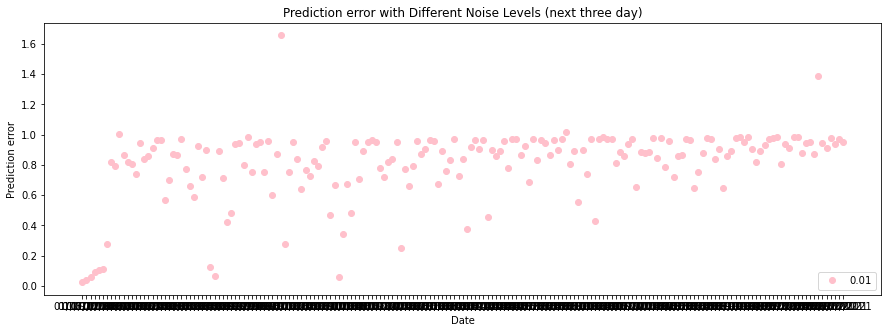

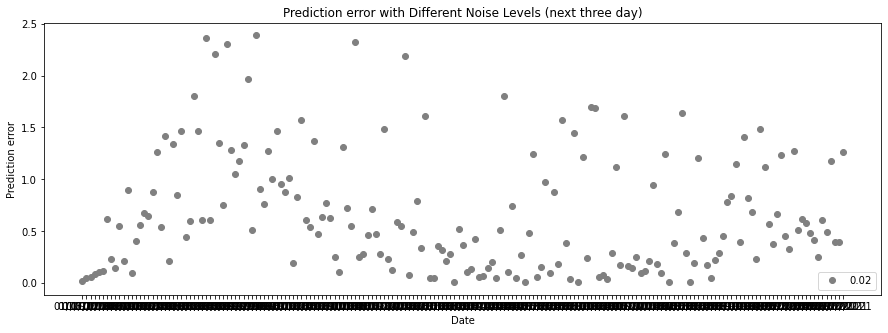

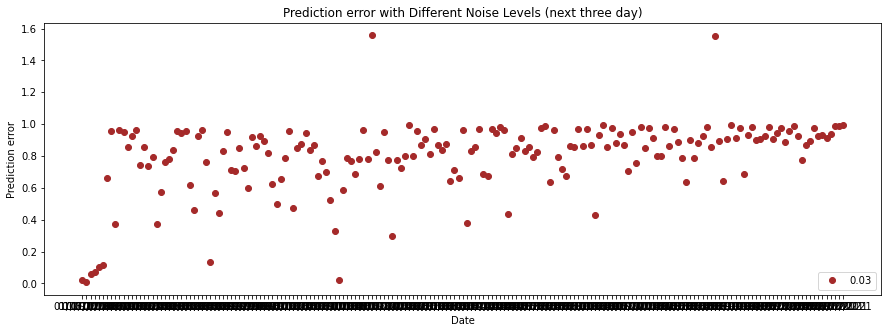

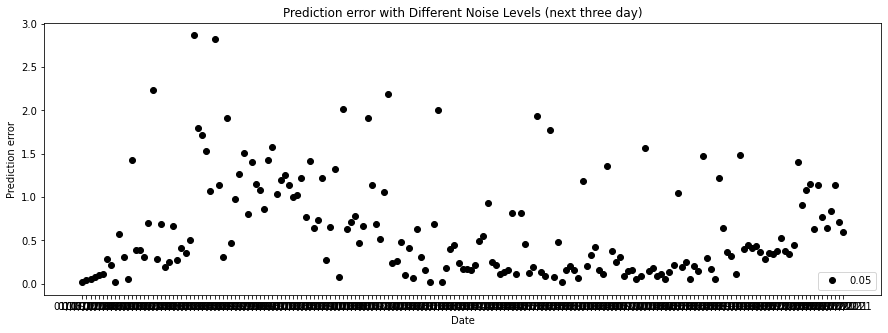

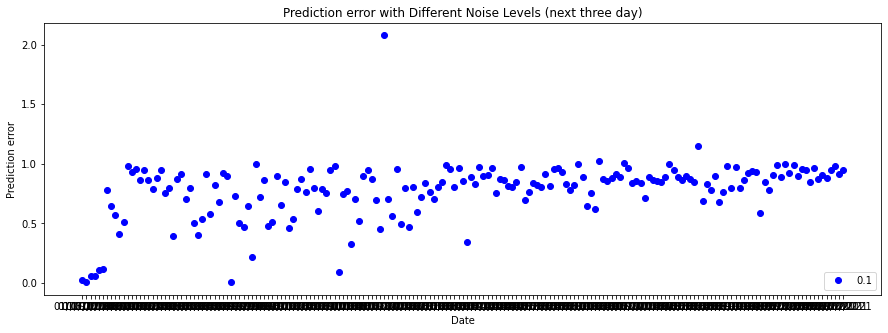

In [26]:
error_res_all=predict(2)

output.detach().numpy()[:,0:2]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("three")
IndividualGraphing("three")

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.031165,0.031127,0.031041,0.031498,0.031533,0.029841,0.026361,0.034736,0.019313,0.022321
01/09/2006,0.050879,0.051086,0.050346,0.050247,0.050698,0.049372,0.053366,0.058214,0.049186,0.043634
01/10/2006,0.077175,0.077175,0.077175,0.077175,0.077175,0.077175,0.077175,0.077175,0.077175,0.077175
01/11/2006,0.090989,0.090744,0.091288,0.091563,0.090725,0.094567,0.093146,0.092021,0.085636,0.097280
01/12/2006,0.102312,0.102312,0.102312,0.102312,0.102312,0.102312,0.102312,0.102312,0.102312,0.102312
...,...,...,...,...,...,...,...,...,...,...
01/08/2021,0.880124,0.917174,0.890161,0.383124,0.918591,0.372367,0.913877,1.054446,0.848311,0.841533
01/09/2021,0.932726,0.984742,0.928665,1.189983,0.919433,0.368236,0.924293,0.382926,0.932768,0.841829
01/10/2021,0.980000,0.987083,0.943893,0.981720,0.990454,0.894081,0.908740,0.977902,0.847272,0.607470
01/11/2021,0.924663,0.985171,0.983332,0.176628,0.926771,0.706418,0.890142,1.131164,0.951279,0.405374


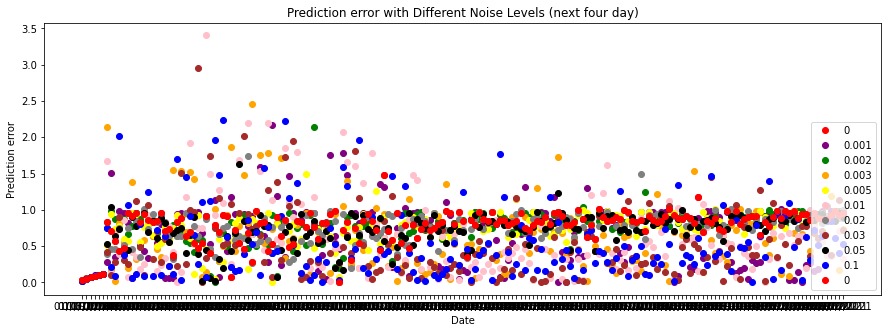

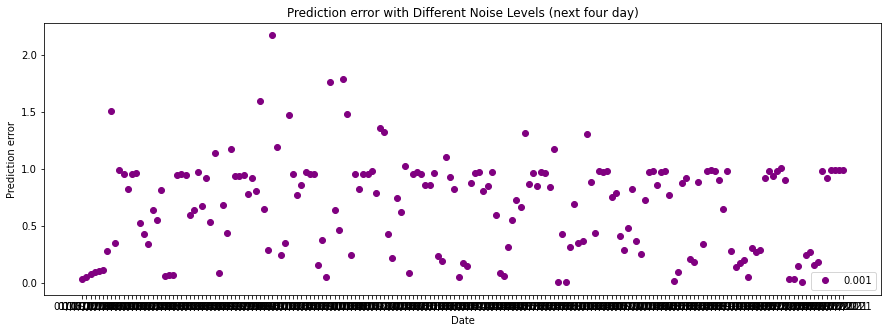

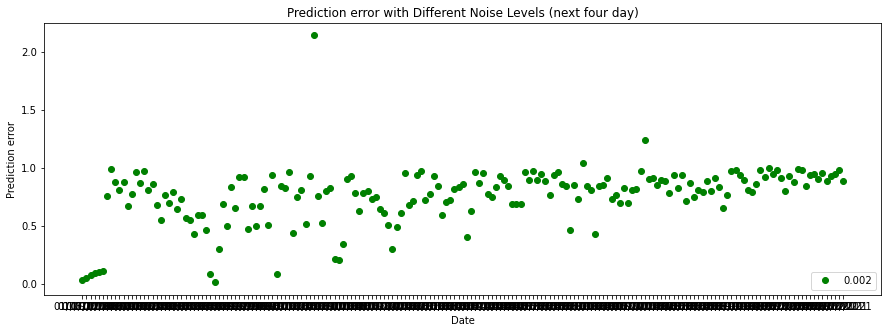

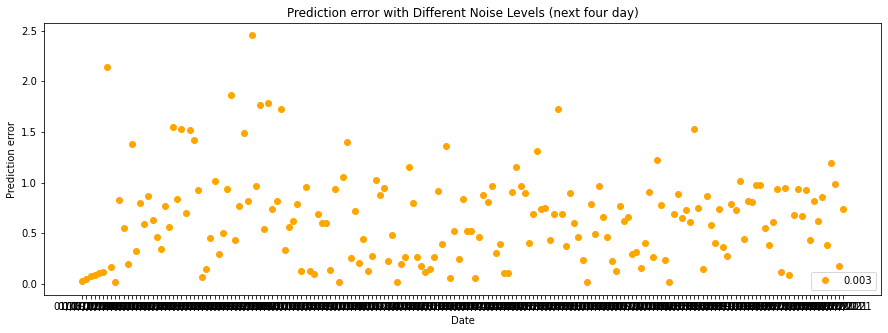

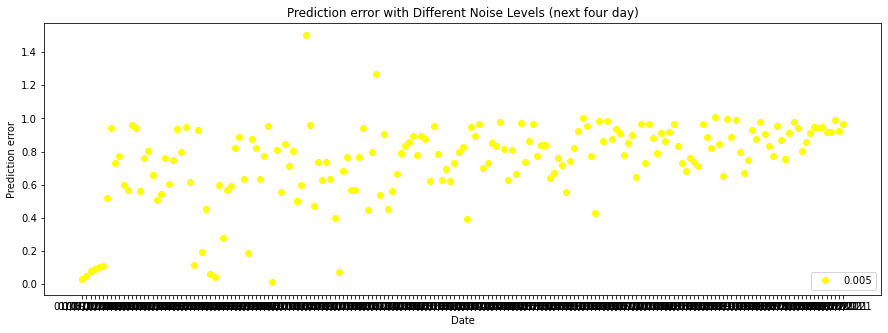

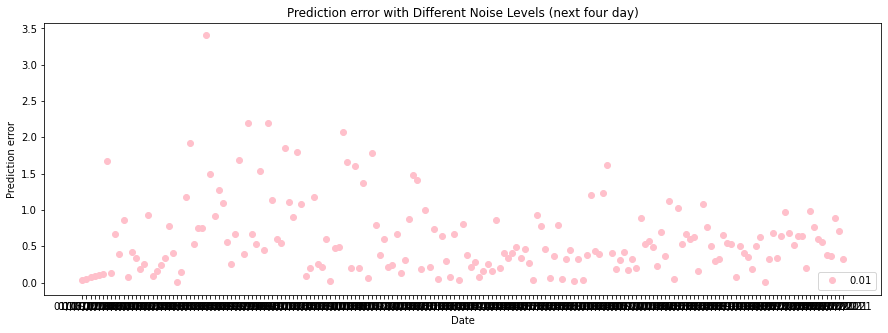

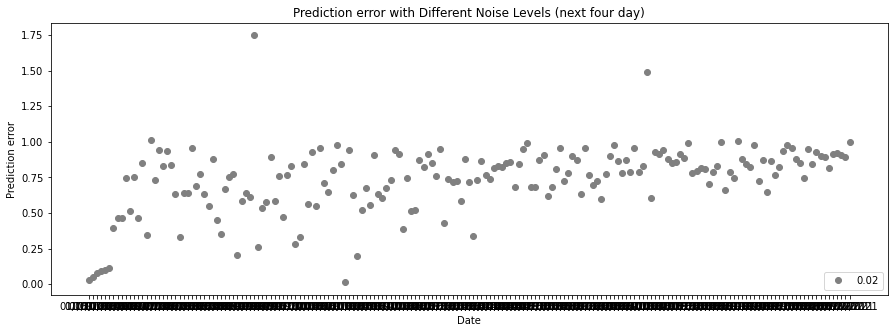

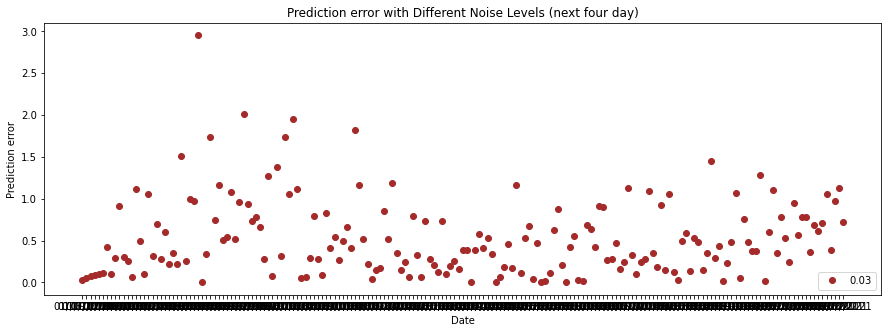

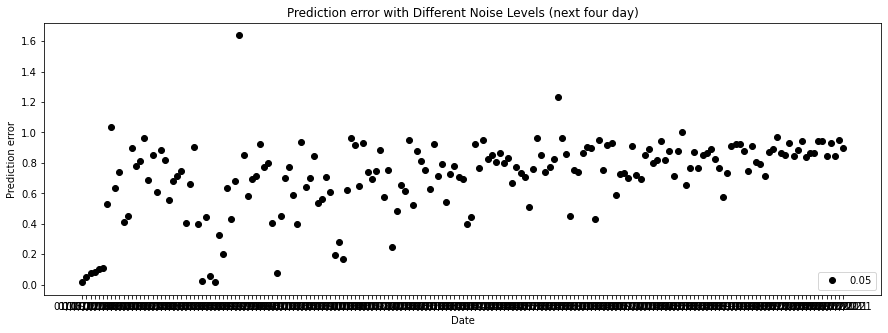

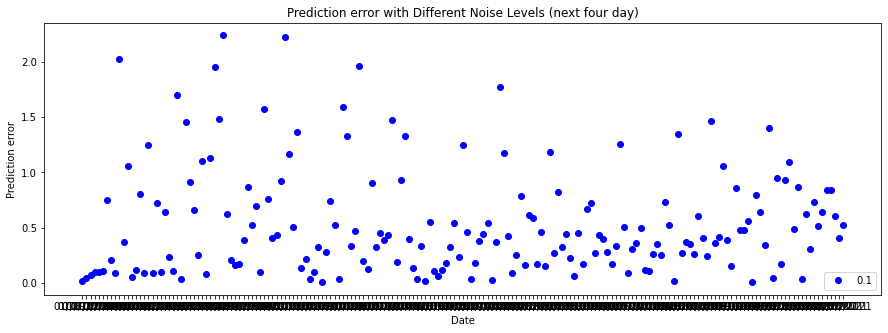

In [27]:
error_res_all=predict(3)

output.detach().numpy()[:,0:3]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("four")
IndividualGraphing("four")